### Import packages

In [1]:
#@title Imports
import os
import sys
import json
import copy
import random
import numpy as np
import pandas as pd
import keras
from tqdm import tqdm
from keras.utils import np_utils

!pip install torch==1.8.1
import torch
torch.set_default_dtype(torch.float32)
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as nnf
softplus = torch.nn.Softplus()
import torch.optim as torchopt

!pip install pyro-ppl==1.3.0
import pyro
from pyro import poutine
import pyro.distributions as dist
from pyro.optim import Adam
import pyro.optim as pyroopt
from pyro.nn import PyroModule
from pyro.infer import SVI, Trace_ELBO, TraceMeanField_ELBO
from pyro.distributions import Normal, Categorical, OneHotCategorical

import warnings
warnings.filterwarnings('ignore')
from keras.datasets import mnist
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 804.1 MB 2.3 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.12.0+cu113 requires torch==1.11.0, but you have torch 1.8.1 which is incompatible.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.8.1 which is incompatible.
torchaudio 0.11.0+cu113 requires torch==1.11.0, but you have torch 1.8.1 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 495 kB 5.3 MB/s 


In [2]:
# set device 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
 #importing the dataset
dt = pd.read_csv('/content/drive/My Drive/smart_grid_stability_augmented.csv')

In [5]:
dt.replace({'stabf': {'unstable':0, 'stable':1}}, inplace=True)

In [6]:
dt.drop(columns=['stab'])

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,1
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,2.930406,2.376523,9.487627,6.187797,3.343416,-1.449106,-0.658054,-1.236256,0.601709,0.813512,0.779642,0.608385,0
59996,3.392299,2.954947,1.274827,6.894759,4.349512,-0.952437,-1.663661,-1.733414,0.502079,0.285880,0.567242,0.366120,1
59997,2.364034,8.776391,2.842030,1.008906,4.299976,-0.943884,-1.380719,-1.975373,0.487838,0.149286,0.986505,0.145984,1
59998,9.631511,2.757071,3.994398,7.821347,2.514755,-0.649915,-0.966330,-0.898510,0.365246,0.889118,0.587558,0.818391,0


In [7]:
labels = torch.tensor(dt["stabf"].values, dtype=torch.float)

In [8]:
# split the data into inputs and outputs
df = dt.iloc[:, :12]

In [9]:
# dataset normalization
df = (df-df.min())/(df.max()-df.min())

In [10]:

# train-test split
#x_train= features[0:len(features)-1000]
#y_train=labels[0:len(labels)-1000]

In [11]:
# torch tensor of features
features = torch.stack([torch.tensor(df[colname].values, dtype=torch.float) for colname in df], dim=1)

# train-test split
x_train= features[0:len(features)-1000]
y_train=labels[0:len(labels)-1000]


x_test= features[len(features)-1000:len(features)]
y_test=labels[len(labels)-1000:len(labels)]



print("x_train.shape =", x_train.shape,"\ny_train.shape =", y_train.shape)
print("\nx_test.shape =", x_test.shape,"\ny_test.shape =", y_test.shape)

x_train.shape = torch.Size([59000, 12]) 
y_train.shape = torch.Size([59000])

x_test.shape = torch.Size([1000, 12]) 
y_test.shape = torch.Size([1000])


In [12]:
x_train[0].shape

torch.Size([12])

In [13]:
batch_size=1

### Deterministic Neural Network


In [14]:
# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [16]:
class DeterministicNetwork(nn.Module):
  
    def __init__(self):

        # initialize nn.Module
        super(DeterministicNetwork, self).__init__()

    
        # architecture
        self.model = nn.Sequential(
                    nn.Linear(12, 100),
                    nn.ReLU(),
                    nn.Linear(100, 2))
    
        self.name = "deterministic_network"
      

    def forward(self, inputs, *args, **kwargs):
        """ Compute predictions on `inputs`. """
        return self.model(inputs)

    def train(self, x_train, y_train, lr, epochs, device):
        """ Train network. """
        random.seed(0)

        # DataLoader combines a dataset and a sampler, and provides an 
        # iterable over the given dataset
        train_loader = DataLoader(dataset=list(zip(x_train, y_train)), 
                                  batch_size=batch_size, shuffle=False)

        # send network to device
        self.to(device)

        # set optimizer and loss function for training
        optimizer = torchopt.Adam(params=self.parameters(), lr=lr)
        loss_fn = nn.CrossEntropyLoss()
      
        
        for epoch in range(epochs):
            total_loss = 0

            for x_batch, y_batch in train_loader:

                # send data to device
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                

                ### loss optimization ###
                outputs = self.forward(x_batch) # forward pass
              

                # reset gradients w.r.t. network parameters
                optimizer.zero_grad() 

                # loss on predicted labels vs true labels
                loss = loss_fn(outputs, y_batch.long()) 
                

                # backward pass: computes the derivative of the loss w.r.t.
                # the parameters using backpropagation.
                loss.backward() 

                # update parameters, i.e. take a step based on the gradients 
                # of the parameters.
                optimizer.step() 
                #########################

                # update training loss
                total_loss += loss.data.item() / len(train_loader.dataset)
        
            print(f"\n[Epoch {epoch + 1}]\t loss: {total_loss:.8f}", end="\t")

    def save(self, savedir):
        """ Save network weights. """
        self.to("cpu") # send network to cpu
        os.makedirs(savedir, exist_ok=True)
        torch.save(self.state_dict(), os.path.join(savedir, self.name+"_weights.pt"))
      
    def load(self, savedir, device):
        """ Load network weights. """
        self.load_state_dict(torch.load(os.path.join(savedir, self.name+"_weights.pt")))
        self.to(device)
      
    def evaluate(self, x_test, y_test, device, *args, **kwargs):
        """ Evaluate network on test set. """
        random.seed(0)
        self.to(device)
        y_pred = []
        y_true = []

        test_loader = DataLoader(dataset=list(zip(x_test, y_test)), batch_size=batch_size, shuffle=False)       

        # disable gradients computation
        with torch.no_grad():

            correct_predictions = 0

            # compute predictions on mini-batch
            for x_batch, y_batch in test_loader:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device).argmax(-1)
                outputs = self(x_batch) # self.forward(x_batch)
                predictions = outputs.argmax(dim=-1)
                correct_predictions += (predictions == y_batch).sum()
                y_pred.extend(predictions.tolist()) 
                y_true.extend(y_test.tolist())

            accuracy = 100 * correct_predictions / len(test_loader.dataset)
                
        print('Classification Report:')
        print(classification_report(y_test, y_pred, labels=[1,0], digits=4))       
        cm_det = confusion_matrix(y_test, y_pred)
        ax= plt.subplot()
        sns.heatmap(cm_det, annot=True, ax = ax, cmap='Blues', fmt="d")
        ax.set_title('Confusion Matrix')
        ax.set_xlabel('Predicted Labels')
        ax.set_ylabel('True Labels')
        
        ax.xaxis.set_ticklabels(['STABLE', 'UNSTABLE'])
        ax.yaxis.set_ticklabels(['STABLE', 'UNSTABLE'])
        
        return accuracy

In [119]:
det_model = DeterministicNetwork()
det_model.train(x_train=x_train, y_train=y_train, lr=0.01, epochs=30, device=device)


[Epoch 1]	 loss: 0.24271283	
[Epoch 2]	 loss: 0.19077194	
[Epoch 3]	 loss: 0.18339145	
[Epoch 4]	 loss: 0.17903277	
[Epoch 5]	 loss: 0.17705920	
[Epoch 6]	 loss: 0.17511181	
[Epoch 7]	 loss: 0.17378786	
[Epoch 8]	 loss: 0.17298665	
[Epoch 9]	 loss: 0.17232620	
[Epoch 10]	 loss: 0.17184649	
[Epoch 11]	 loss: 0.17166095	
[Epoch 12]	 loss: 0.17182324	
[Epoch 13]	 loss: 0.17184420	
[Epoch 14]	 loss: 0.17140966	
[Epoch 15]	 loss: 0.17147586	
[Epoch 16]	 loss: 0.17130189	
[Epoch 17]	 loss: 0.17127535	
[Epoch 18]	 loss: 0.17123315	
[Epoch 19]	 loss: 0.17125486	
[Epoch 20]	 loss: 0.17136184	
[Epoch 21]	 loss: 0.17119827	
[Epoch 22]	 loss: 0.17127491	
[Epoch 23]	 loss: 0.17136890	
[Epoch 24]	 loss: 0.17123221	
[Epoch 25]	 loss: 0.17109725	
[Epoch 26]	 loss: 0.17134686	
[Epoch 27]	 loss: 0.17127387	
[Epoch 28]	 loss: 0.17145949	
[Epoch 29]	 loss: 0.17132744	
[Epoch 30]	 loss: 0.17121232	

Classification Report:
              precision    recall  f1-score   support

           1     0.9224    0.8537    0.8867       376
           0     0.9156    0.9567    0.9357       624

    accuracy                         0.9180      1000
   macro avg     0.9190    0.9052    0.9112      1000
weighted avg     0.9182    0.9180    0.9173      1000


Test accuracy: 65.20%


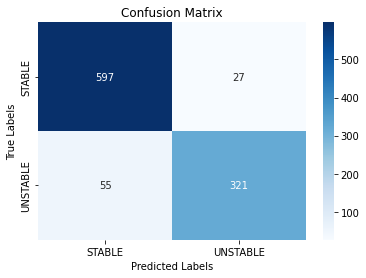

In [120]:
accuracy = det_model.evaluate(x_test, y_test, device=device)
print("\nTest accuracy: %.2f%%" % (accuracy))

### Bayesian Neural Network

In [17]:
class BayesianNetwork(PyroModule):

    def __init__(self):
        # initialize PyroModule
        super(BayesianNetwork, self).__init__()

        # BayesianNetwork extends PyroModule class
        self.det_network = DeterministicNetwork()

        self.name = "bayesian_network"
      
    def model(self, x_data, y_data):
        """ Sets prior distributions and conditions on the observations. """
        priors = {}
    
        # set Gaussian priors on the weights of self.det_network
        for key, value in self.det_network.state_dict().items():
            loc = torch.zeros_like(value)
            scale = torch.ones_like(value)
            prior = Normal(loc=loc, scale=scale)
            priors.update({str(key):prior})

        # pyro.random_module places `priors` over the parameters of the nn.Module 
        # self.det_network and returns a distribution, which upon calling 
        # samples a new nn.Module (`lifted_module`)
        lifted_module = pyro.random_module("module", self.det_network, priors)()

        # samples are conditionally independent w.r.t. the observed data
        with pyro.plate("data", len(x_data)):
            out = lifted_module(x_data) # out.shape = (batch_size, num_classes)
            obs = pyro.sample("obs", Categorical(logits=out), obs=y_data) # obs.shape = (batch_size)

    def guide(self, x_data, y_data=None):
        """ Samples from the Variational distribution and returns predictions. """

        # take random samples of det_network's weights from the chosen variational family
        dists = {}
        for key, value in self.det_network.state_dict().items():

            # torch.randn_like(x) builds a random tensor whose shape equals x.shape
            loc = pyro.param(str(f"{key}_loc"), torch.randn_like(value)) 
            scale = pyro.param(str(f"{key}_scale"), torch.randn_like(value))

            # softplus is a smooth approximation to the ReLU function
            # which constraints the scale tensor to positive values
            distr = Normal(loc=loc, scale=softplus(scale))

            # add key-value pair to the samples dictionary
            dists.update({str(key):distr})

        # define a random module from the dictionary of distributions
        lifted_module = pyro.random_module("module", self.det_network, dists)()

        with pyro.plate("data", len(x_data)):

            # compute predictions on `x_data`
            out = lifted_module(x_data)
            preds = nnf.softmax(out, dim=-1)
            return preds
        
    def forward(self, inputs, n_samples=10, sample_idx=None, avg_prediction=True):
        """ Compute predictions on `inputs`. 
        `n_samples` is the number of samples from the posterior distribution.
        If `sample_idx` is provided, it is used as a seed for sampling a single
        model from the Variational family.
        If `avg_prediction` is True, it returns the average prediction on 
        `inputs`, otherwise it returns all predictions 
        """
        if sample_idx:
            # set random seeds for both torch and pyro
            random.seed(sample_idx)
            pyro.set_rng_seed(sample_idx)    

            # sample from the guide() function and evaluate it on `inputs`        
            guide_trace = poutine.trace(self.guide).get_trace(inputs)  

            # get the output prediction from the guide() function
            preds = [guide_trace.nodes['_RETURN']['value']]
        
        else:
            preds = []
            # take multiple samples
            for _ in range(n_samples):         
                guide_trace = poutine.trace(self.guide).get_trace(inputs)  
                preds.append(guide_trace.nodes['_RETURN']['value'])
        
        # list of tensors to tensor
        # preds.shape = (n_samples, batch_size, n_classes)
        preds = torch.stack(preds)

        # return predictions 
        return preds.mean(0) if avg_prediction else preds

    def train(self, x_train, y_train, lr, epochs, device):
        """ Learn network's weights using SVI. """
        random.seed(0)
        pyro.set_rng_seed(0)
        pyro.clear_param_store()

        train_loader = DataLoader(dataset=list(zip(x_train, y_train)), 
                                  batch_size=batch_size, shuffle=False)
 
        # send bayesian network and deterministic network to device
        self.to(device)
        self.det_network.to(device)

        # ELBO loss minimization
        optimizer = pyro.optim.Adam({"lr":lr})
        elbo = TraceMeanField_ELBO()
        svi = SVI(self.model, self.guide, optimizer, loss=elbo)

        for epoch in range(epochs):
            loss = 0.0

            for x_batch, y_batch in train_loader:

                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device).argmax(-1)
                loss += svi.step(x_data=x_batch, y_data=y_batch)

            total_loss = loss / len(train_loader.dataset)
            print(f"Epoch {epoch + 1}]\t loss: {total_loss:.2f}")

          
    def save(self, savedir):
        """ Save posterior weights. """
        os.makedirs(savedir, exist_ok=True)
        fullpath = os.path.join(savedir, self.name+"_weights.pt")
        param_store = pyro.get_param_store()
        param_store.save(fullpath)
        
    def load(self, savedir, device):
        """ Load posterior weights. """
        fullpath = os.path.join(savedir, self.name+"_weights.pt")
        param_store = pyro.get_param_store()
        param_store.load(os.path.join(savedir, fullpath))
        for key, value in param_store.items():
            param_store.replace_param(key, value.to(device), value)

    def evaluate(self, x_test, y_test, device, n_samples=10, avg_prediction=True):
        """ Evaluate network on test set. """
        random.seed(0)
        pyro.set_rng_seed(0)  
        y_pred = []
        y_true = []

        test_loader = DataLoader(dataset=list(zip(x_test, y_test)), 
                                 batch_size=batch_size, shuffle=False)
        
        self.to(device)
        self.det_network.to(device)

        # disable gradients computation
        with torch.no_grad():

            correct_predictions = 0.0

            # compute predictions on mini-batch
            for x_batch, y_batch in test_loader:

                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device).argmax(-1)

                outputs = self.forward(x_batch, n_samples=n_samples, avg_prediction=avg_prediction)
                predictions = outputs.to(device).argmax(-1)
                correct_predictions += (predictions == y_batch).sum().item()

                y_pred.extend(predictions.tolist()) 
                y_true.extend(y_test.tolist())

            accuracy = 100 * correct_predictions / len(test_loader.dataset)
                
        print('Classification Report:')
        print(classification_report(y_test, y_pred, labels=[1,0], digits=4))       
        cm_det = confusion_matrix(y_test, y_pred)
        ax= plt.subplot()
        sns.heatmap(cm_det, annot=True, ax = ax, cmap='Blues', fmt="d")
        ax.set_title('Confusion Matrix')
        ax.set_xlabel('Predicted Labels')
        ax.set_ylabel('True Labels')
        
        ax.xaxis.set_ticklabels(['STABLE', 'UNSTABLE'])
        ax.yaxis.set_ticklabels(['STABLE', 'UNSTABLE'])
        
        return accuracy

In [18]:
bay_model = BayesianNetwork()
bay_model.train(x_train=x_train, y_train=y_train, lr=0.01, epochs=30, device=device)

Epoch 1]	 loss: 6.59
Epoch 2]	 loss: 4.97
Epoch 3]	 loss: 4.91
Epoch 4]	 loss: 4.94
Epoch 5]	 loss: 4.92
Epoch 6]	 loss: 5.02
Epoch 7]	 loss: 4.98
Epoch 8]	 loss: 4.95
Epoch 9]	 loss: 4.93
Epoch 10]	 loss: 4.93
Epoch 11]	 loss: 4.92
Epoch 12]	 loss: 4.94
Epoch 13]	 loss: 4.97
Epoch 14]	 loss: 4.95
Epoch 15]	 loss: 4.95
Epoch 16]	 loss: 4.92
Epoch 17]	 loss: 4.96
Epoch 18]	 loss: 4.95
Epoch 19]	 loss: 4.94
Epoch 20]	 loss: 4.94
Epoch 21]	 loss: 4.92
Epoch 22]	 loss: 4.97
Epoch 23]	 loss: 4.96
Epoch 24]	 loss: 4.94
Epoch 25]	 loss: 4.94
Epoch 26]	 loss: 5.00
Epoch 27]	 loss: 4.97
Epoch 28]	 loss: 4.93
Epoch 29]	 loss: 5.01
Epoch 30]	 loss: 4.93


Classification Report:
              precision    recall  f1-score   support

           1     0.0000    0.0000    0.0000       376
           0     0.6240    1.0000    0.7685       624

    accuracy                         0.6240      1000
   macro avg     0.3120    0.5000    0.3842      1000
weighted avg     0.3894    0.6240    0.4795      1000


Test accuracy: 100.00%


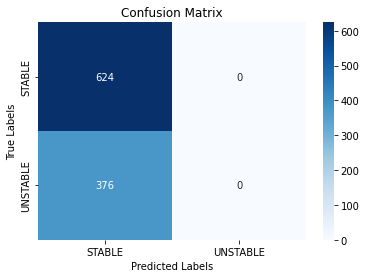

In [19]:
accuracy = bay_model.evaluate(x_test, y_test, device=device, n_samples=10)
print("\nTest accuracy: %.2f%%" % (accuracy))